# 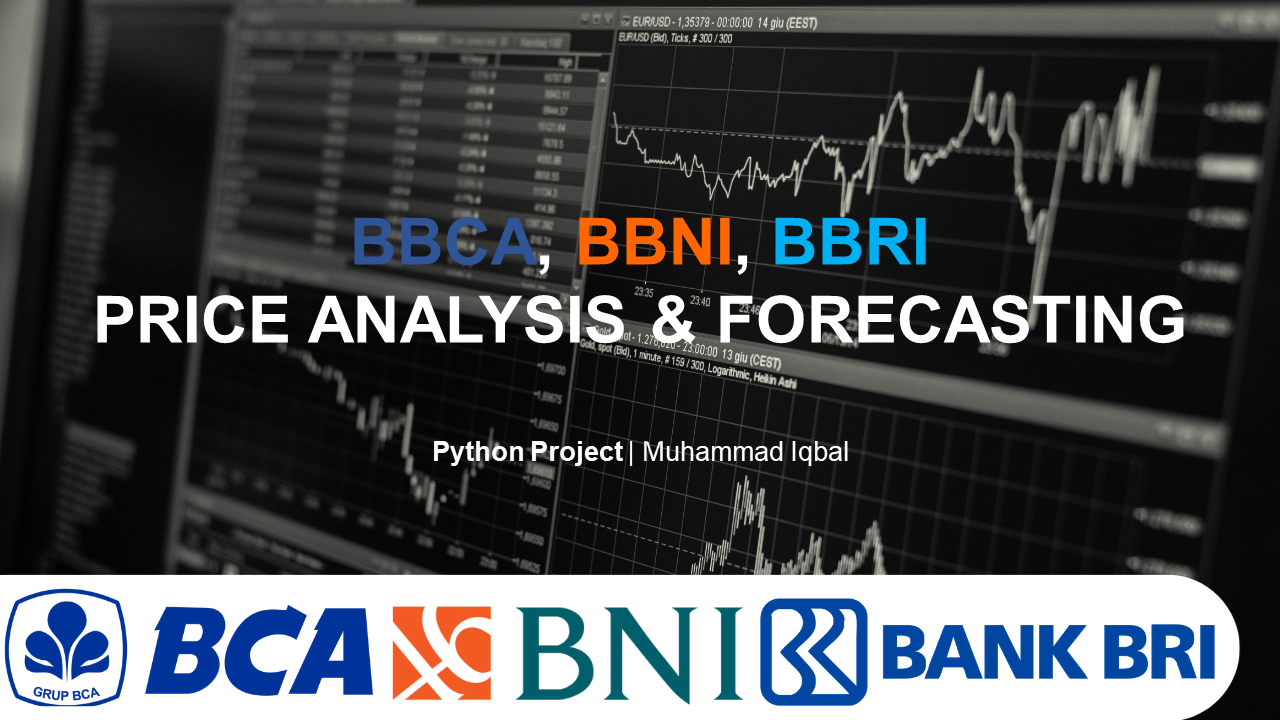

**Problem Statement**

The stock trading of Bank Central Asia (BBCA), Bank Negara Indonesia (BBNI), and Bank Rakyat Indonesia (BBRI) exhibits significant price fluctuations during specific time periods. The objective of this project is to conduct a comprehensive analysis of stock prices, identify significant trends, and develop forecasting models to assist investors in making more informed investment decisions. Unpredictable stock price fluctuations pose a significant challenge for investors. By understanding trends and having reliable predictive models, investors can mitigate risks and make more informed investment decisions. The project will focus on the analysis and prediction of stock prices for BBCA, BBNI, and BBRI over a specific period (1 jan 2019- 10 jan 2024). The data used will include daily closing prices, trading volumes, and other technical indicators. The developed predictive model will be evaluated based on its performance in forecasting future stock prices.

- The dataset utilized originates from Kaggle Account ([Here](https://www.kaggle.com/caesarmario/datasets)).
- The source code for this project is available on my GitHub ([Here](https://github.com/iqbalstilllearning/BBCA-BBNI-BBRI-Price-Analysis-Forecasting))

**Research Questions**
1. What was the extent of the change in closing prices and trading volumes of shares over time? What is comparative analysis of stocks in each banks?
2. What was the percentage growth in stock prices for each bank?
3. What was the daily stock returns for each bank?
4. How can one conduct technical analysis of stocks using candlestick charts?
5. How effective are LSTM models in forecasting stock prices? and what are the results of forecasting for the next 30 days?

# Library and Explore Data

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import datetime as dt
import plotly.graph_objects as go
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam
from math import sqrt

import warnings
warnings.filterwarnings("ignore")


In [2]:
df_bca = pd.read_csv('BBCA.JK.csv')
df_bri = pd.read_csv('BBRI.JK.csv')
df_bni = pd.read_csv('BBNI.JK.csv')

In [3]:
df_bca['Bank_Name'] = 'BCA'
df_bri['Bank_Name'] = 'BRI'
df_bni['Bank_Name'] = 'BNI'

In [4]:
df_bca.dropna(inplace=True)
df_bni.dropna(inplace=True)
df_bri.dropna(inplace=True)

In [5]:
df = pd.concat([df_bca, df_bri, df_bni], ignore_index=True)
df

Date    Open    High     Low   Close    Adj Close      Volume  \
0     2019-01-01  5200.0  5200.0  5200.0  5200.0  4736.542969         0.0   
1     2019-01-02  5200.0  5245.0  5200.0  5240.0  4772.979004  35956000.0   
2     2019-01-03  5200.0  5220.0  5115.0  5180.0  4718.325195  72358000.0   
3     2019-01-04  5175.0  5205.0  5125.0  5205.0  4741.097168  51465000.0   
4     2019-01-07  5265.0  5325.0  5245.0  5245.0  4777.533203  73438000.0   
...          ...     ...     ...     ...     ...          ...         ...   
3711  2024-01-04  5350.0  5675.0  5325.0  5600.0  5600.000000  77162400.0   
3712  2024-01-05  5675.0  5750.0  5575.0  5575.0  5575.000000  69463500.0   
3713  2024-01-08  5575.0  5650.0  5550.0  5575.0  5575.000000  60606600.0   
3714  2024-01-09  5600.0  5650.0  5600.0  5650.0  5650.000000  34897000.0   
3715  2024-01-10  5625.0  5675.0  5575.0  5600.0  5600.000000  37988500.0   

     Bank_Name  
0          BCA  
1          BCA  
2          BCA  
3          BCA  
4          BCA  
...        ...  
3711       BNI  
3712       BNI  
3713       BNI  
3714       BNI  
3715       BNI  

[3716 rows x 8 columns]

In [6]:
def info_func(df):
    
    df['Date'] = pd.to_datetime(df['Date'])
    df.info()
    print("----"*20)
    
    null = df.isnull().sum()
    print(null)
    print("----"*20)
    
    delta = (pd.to_datetime(df['Date']).max() - pd.to_datetime(df['Date']).min())
    print("Time range of stocks dataset:\n", delta)
    print("----"*20) 

info_func(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3716 entries, 0 to 3715
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3716 non-null   datetime64[ns]
 1   Open       3716 non-null   float64       
 2   High       3716 non-null   float64       
 3   Low        3716 non-null   float64       
 4   Close      3716 non-null   float64       
 5   Adj Close  3716 non-null   float64       
 6   Volume     3716 non-null   float64       
 7   Bank_Name  3716 non-null   object        
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 232.4+ KB
--------------------------------------------------------------------------------
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Bank_Name    0
dtype: int64
--------------------------------------------------------------------------------
Time range of stocks dataset:
 1835 days 00:00:00
------

In [7]:
df.dropna(inplace=True)

In [8]:
df.describe()

Date         Open         High          Low  \
count                           3716  3716.000000  3716.000000  3716.000000   
mean   2021-06-27 16:04:08.008611328  5057.603075  5107.574144  5002.812490   
min              2019-01-01 00:00:00  1580.000000  1705.000000  1485.000000   
25%              2020-03-15 06:00:00  3940.000000  3975.000000  3890.000000   
50%              2021-06-30 00:00:00  4580.000000  4625.000000  4537.500000   
75%              2022-10-04 00:00:00  6060.000000  6101.250000  6005.000000   
max              2024-01-10 00:00:00  9650.000000  9650.000000  9575.000000   
std                              NaN  1760.609685  1768.794393  1755.950124   

             Close    Adj Close        Volume  
count  3716.000000  3716.000000  3.716000e+03  
mean   5054.219243  4672.890267  9.997289e+07  
min    1580.000000  1375.536499  0.000000e+00  
25%    3930.000000  3371.764648  5.141545e+07  
50%    4580.000000  4185.224609  8.056475e+07  
75%    6055.000000  5678.627441  1.227840e+08  
max    9625.000000  9625.000000  8.984537e+08  
std    1763.450249  1852.527589  7.840847e+07

In [9]:
df

Date    Open    High     Low   Close    Adj Close      Volume  \
0    2019-01-01  5200.0  5200.0  5200.0  5200.0  4736.542969         0.0   
1    2019-01-02  5200.0  5245.0  5200.0  5240.0  4772.979004  35956000.0   
2    2019-01-03  5200.0  5220.0  5115.0  5180.0  4718.325195  72358000.0   
3    2019-01-04  5175.0  5205.0  5125.0  5205.0  4741.097168  51465000.0   
4    2019-01-07  5265.0  5325.0  5245.0  5245.0  4777.533203  73438000.0   
...         ...     ...     ...     ...     ...          ...         ...   
3711 2024-01-04  5350.0  5675.0  5325.0  5600.0  5600.000000  77162400.0   
3712 2024-01-05  5675.0  5750.0  5575.0  5575.0  5575.000000  69463500.0   
3713 2024-01-08  5575.0  5650.0  5550.0  5575.0  5575.000000  60606600.0   
3714 2024-01-09  5600.0  5650.0  5600.0  5650.0  5650.000000  34897000.0   
3715 2024-01-10  5625.0  5675.0  5575.0  5600.0  5600.000000  37988500.0   

     Bank_Name  
0          BCA  
1          BCA  
2          BCA  
3          BCA  
4          BCA  
...        ...  
3711       BNI  
3712       BNI  
3713       BNI  
3714       BNI  
3715       BNI  

[3716 rows x 8 columns]

# 1. What was the extent of the change in closing prices and trading volumes of shares over time? What is comparative analysis of stocks in each banks?

CLOSING PRICE

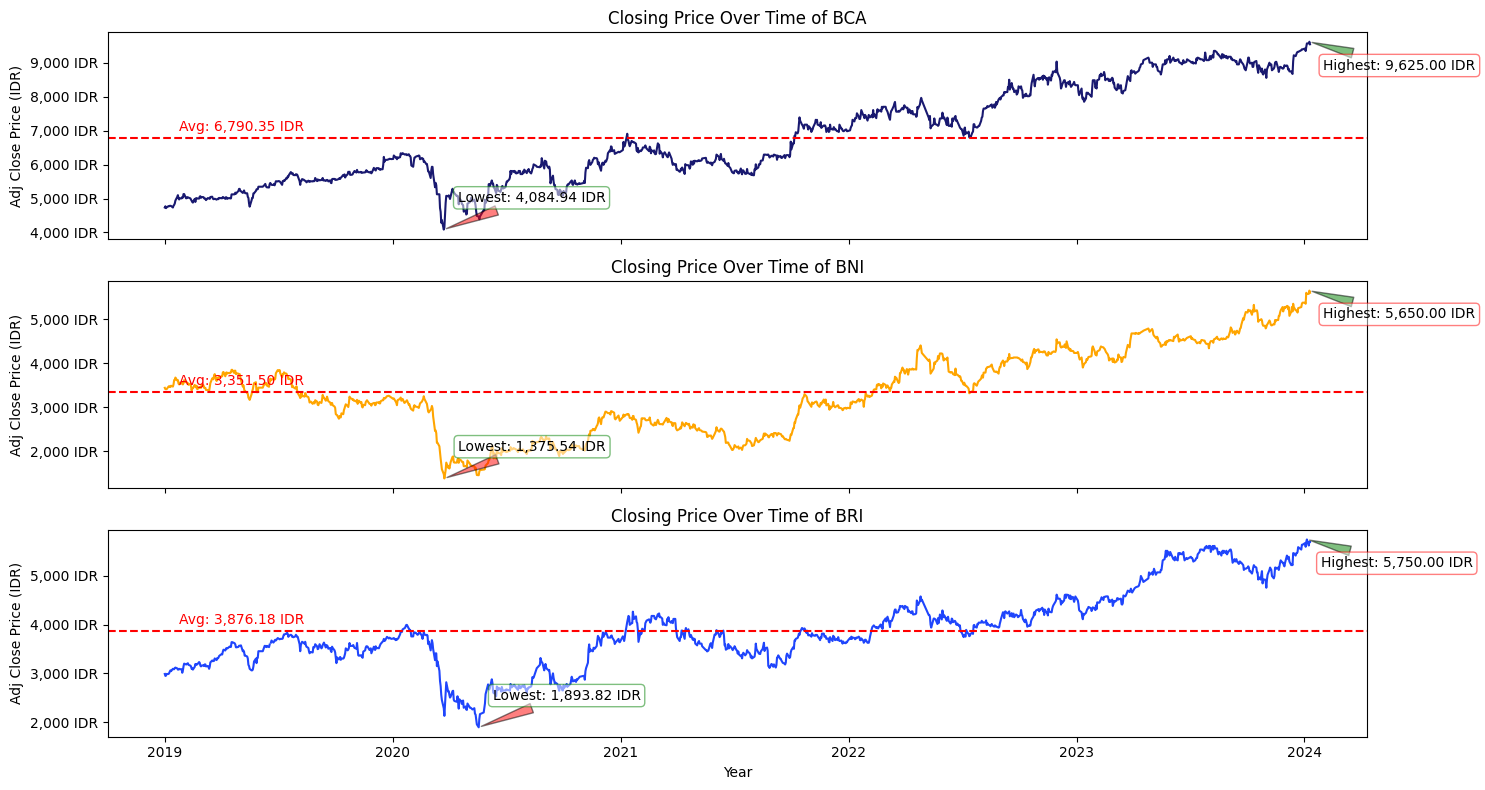

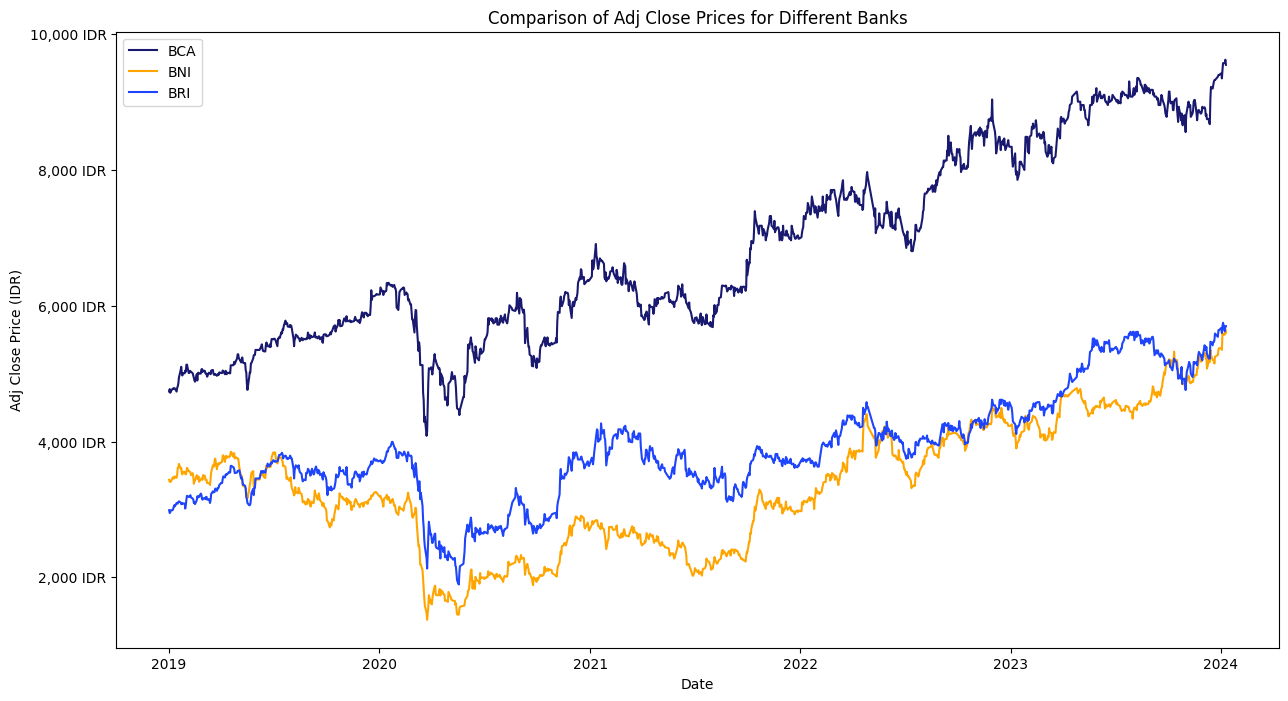

In [10]:
colors = ['#191970', '#FFA500', '#1F45FC']

def closing_price(df, column_name):
    # Pivot the DataFrame to get adjusted closing prices for each bank over time
    pivot_df = df.pivot(index='Date', columns='Bank_Name', values=column_name)
    
    # Create separate subplots for each bank
    fig, axes = plt.subplots(len(pivot_df.columns), 1, figsize=(15, 8), sharex=True)


    # Loop through each bank using enumerate
    for i, (bank, ax, color) in enumerate(zip(pivot_df.columns, axes, colors), 1):
        ax.plot(pivot_df.index, pivot_df[bank], label=bank, color=color)
        ax.set_ylabel(f'{column_name} Price (IDR)')  # Add Indonesian Rupiah unit
        ax.get_yaxis().set_major_formatter(ticker.StrMethodFormatter('{x:,.0f} IDR'))
        ax.set_title(f'Closing Price Over Time of {bank}')

        # Add labels for highest and lowest prices on each subplot
        ax.annotate(f'Highest: {pivot_df[bank].max():,.2f} IDR', 
                    xy=(pivot_df.idxmax()[bank], pivot_df[bank].max()), 
                    xytext=(10, -20),
                    textcoords='offset points',
                    arrowprops=dict(facecolor='g', arrowstyle='wedge,tail_width=0.7', alpha=0.5),
                    bbox=dict(boxstyle='round,pad=0.3', edgecolor='r', facecolor='white', alpha=0.5))

        ax.annotate(f'Lowest: {pivot_df[bank].min():,.2f} IDR', 
                    xy=(pivot_df.idxmin()[bank], pivot_df[bank].min()), 
                    xytext=(10, 20),
                    textcoords='offset points',
                    arrowprops=dict(facecolor='r', arrowstyle='wedge,tail_width=0.7', alpha=0.5),
                    bbox=dict(boxstyle='round,pad=0.3', edgecolor='g', facecolor='white', alpha=0.5))

        # Add average information
        avg_price = pivot_df[bank].mean()
        ax.axhline(y=avg_price, color='r', linestyle='--', label=f'Average: {avg_price:,.2f} IDR')
        ax.annotate(f'Avg: {avg_price:,.2f} IDR', 
                    xy=(pivot_df.index[0], avg_price), 
                    xytext=(10, 5),
                    textcoords='offset points',
                    color='r')

    # Add labels and title for the x-axis
    axes[-1].set_xlabel('Year')

    # Adjust layout
    plt.tight_layout()
    plt.show()

    # Create a comparison plot of adjusted closing prices
    plt.figure(figsize=(15, 8))

    for i, bank in enumerate(pivot_df.columns):
        plt.plot(pivot_df.index, pivot_df[bank], label=bank, color=colors[i])

    # Use formatter for IDR currency on the y-axis
    plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f} IDR'))

    # Add labels and title
    plt.xlabel('Date')
    plt.ylabel(f'{column_name} Price (IDR)')  # Add Indonesian Rupiah unit
    plt.title(f'Comparison of {column_name} Prices for Different Banks')
    plt.legend()
    plt.show()

# Use the function to plot adjusted closing prices (Adj Close)
closing_price(df, 'Adj Close')


BBCA:

- Highest closing price: 9,625.00 IDR
- Lowest closing price: 4,084.94 IDR
- Average closing price: 6,790.35 IDR
- Range (Highest - Lowest): 5,540.06 IDR

BBNI:

- Highest closing price: 5,650.00 IDR
- Lowest closing price: 1,375.54 IDR
- Average closing price : 3,351.50 IDR
- Range (Highest - Lowest): 4,274.46 IDR

BBRI:

- Highest closing price: 5,750.00 IDR
- Lowest closing price: 1,893.82 IDR
- Average closing price: 3,876.18 IDR
- Range (Highest - Lowest): 3,856.18 IDR

Key findings:

- All three banks experienced significant fluctuations in their closing prices over the given period, with an overall increasing trend, particularly notable around 2020. Additionally, all three banks showed an upward trend overall, but with varying degrees of volatility.
- BBCA had the highest range of change, followed by BBNI and then BBRI.
- BBCA had the highest overall growth, reaching a closing price of around 9,625 IDR, compared to BNI's 5,650 IDR and BRI's 5,750 IDR.
- BBCA outperformed BNI and BRI in terms of overall price appreciation.
- BNI and BRI had similar growth patterns, with BNI experiencing slightly higher peaks but also deeper dips compared to BRI.
- BNI appeared to be the most volatile, with the largest swings in both directions.
- BBCA and BRI exhibited somewhat less volatility, but still had periods of significant price movements.

TRADING VOLUMES

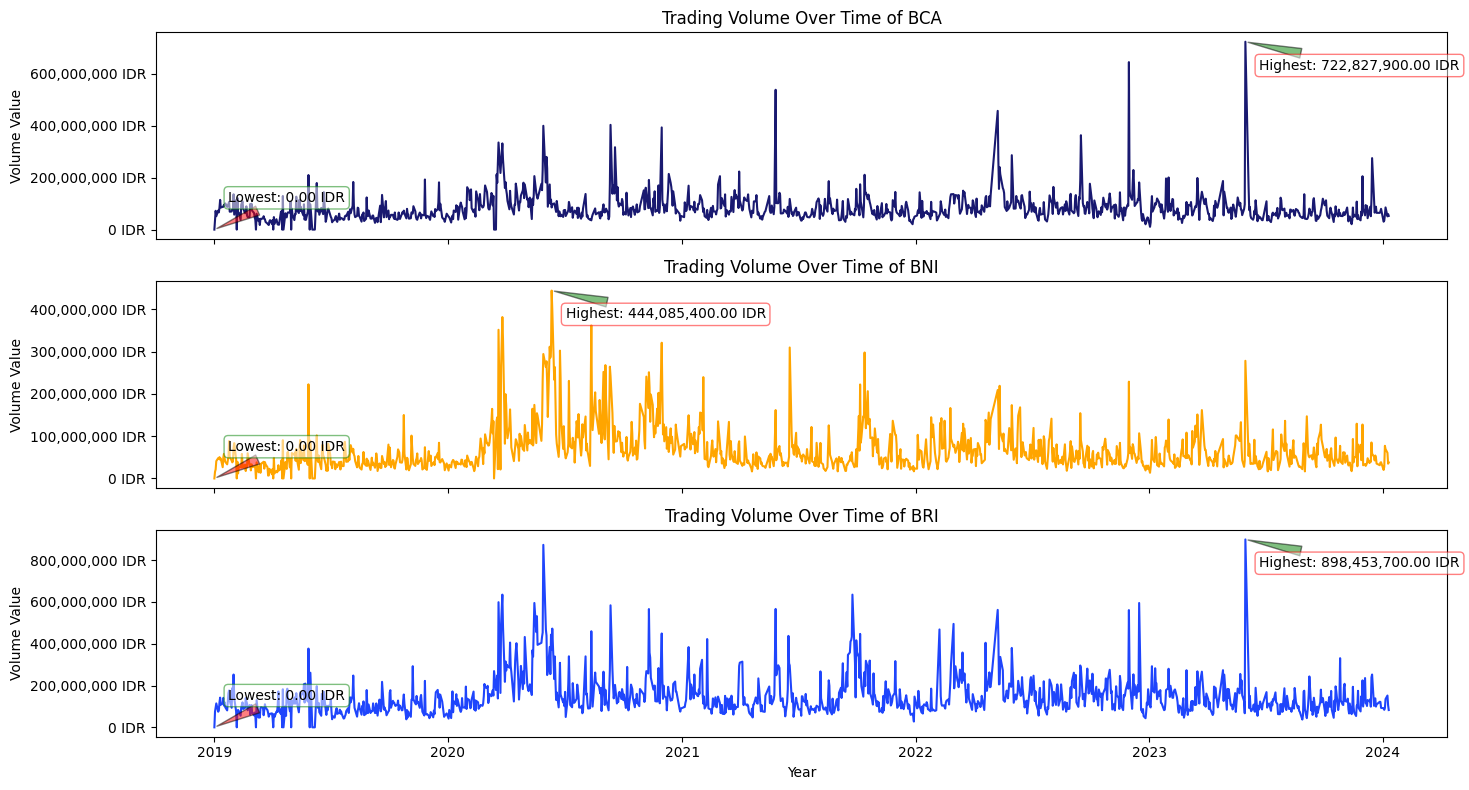

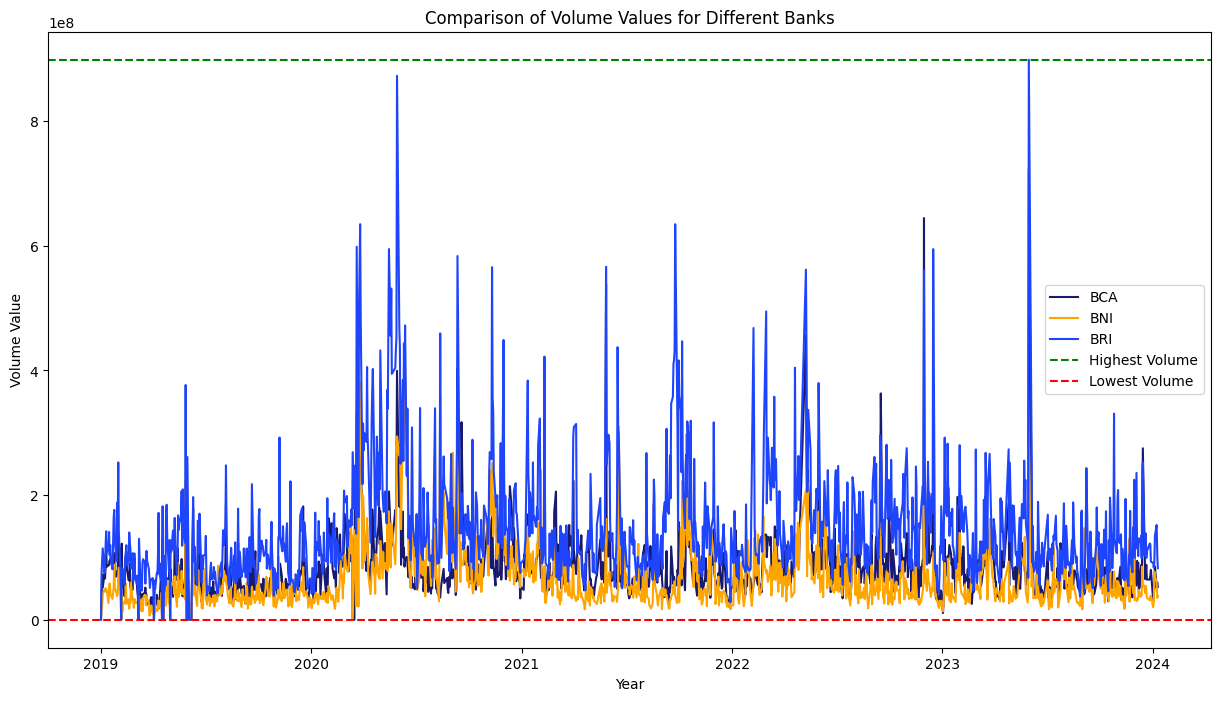

In [11]:
def trading_volumes(df, column_name):
    # Pivot the DataFrame to get trading volumes for each bank over time
    pivot_df = df.pivot(index='Date', columns='Bank_Name', values=column_name)

    # Create separate subplots for each bank
    fig, axes = plt.subplots(len(pivot_df.columns), 1, figsize=(15, 8), sharex=True)

    # Loop through each bank using enumerate
    for i, (bank, ax, color) in enumerate(zip(pivot_df.columns, axes, colors), 1):
        ax.plot(pivot_df.index, pivot_df[bank], label=bank, color=color)
        ax.set_ylabel(f'{column_name} Value')
        ax.get_yaxis().set_major_formatter(ticker.StrMethodFormatter('{x:,.0f} IDR'))
        ax.set_title(f'Trading {column_name} Over Time of {bank}')

        # Add labels for highest and lowest values on each subplot
        ax.annotate(f'Highest: {pivot_df[bank].max():,.2f} IDR', 
                    xy=(pivot_df.idxmax()[bank], pivot_df[bank].max()), 
                    xytext=(10, -20),
                    textcoords='offset points',
                    arrowprops=dict(facecolor='g', arrowstyle='wedge,tail_width=0.7', alpha=0.5),
                    bbox=dict(boxstyle='round,pad=0.3', edgecolor='r', facecolor='white', alpha=0.5))

        ax.annotate(f'Lowest: {pivot_df[bank].min():,.2f} IDR', 
                    xy=(pivot_df.idxmin()[bank], pivot_df[bank].min()), 
                    xytext=(10, 20),
                    textcoords='offset points',
                    arrowprops=dict(facecolor='r', arrowstyle='wedge,tail_width=0.7', alpha=0.5),
                    bbox=dict(boxstyle='round,pad=0.3', edgecolor='g', facecolor='white', alpha=0.5))

    # Add labels and title for the x-axis
    axes[-1].set_xlabel('Year')

    # Adjust layout
    plt.tight_layout()
    plt.show()

    # Create a comparison plot of trading volumes
    plt.figure(figsize=(15, 8))
    for i, bank in enumerate(pivot_df.columns):
        plt.plot(pivot_df.index, pivot_df[bank], label=bank, color=colors[i])

    # Add lines for the highest and lowest values on the overall plot
    plt.axhline(y=pivot_df.max().max(), color='g', linestyle='--', label=f'Highest {column_name}')
    plt.axhline(y=pivot_df.min().min(), color='r', linestyle='--', label=f'Lowest {column_name}')

    # Add labels and title
    plt.xlabel('Year')
    plt.ylabel(f'{column_name} Value')
    plt.title(f'Comparison of {column_name} Values for Different Banks')
    plt.legend()
    plt.show()

# Use the function to plot trading volumes
trading_volumes(df, 'Volume')


BBCA:

- Trading volume seems to have increased steadily from 2019 to 2021, with occasional peaks and dips.
- A significant surge in volume is visible around late 2020 and early 2021, followed by a period of relative stability.
- There appears to be a slight downward trend in volume from late 2021 to 2023.

BNI:

- BNI's trading volume exhibits a more volatile pattern compared to BBCA.
- Several sharp peaks and troughs are noticeable throughout the period, with no clear upward or downward trend.
- The highest volume spike seems to occur around mid-2020, followed by a significant drop and then another smaller peak in late 2021.

BRI:

- BRI's trading volume also shows considerable fluctuations, with several notable peaks and valleys.
- Similar to BNI, there's no consistent upward or downward trend over the period.
- The most prominent volume surges appear to be in late 2019 and early 2020, followed by a period of lower volume and then another peak in late 2021.

Comparative Analysis:

- BBCA generally had the highest and most consistent trading volume compared to BNI and BRI.
- BNI and BRI experienced more extreme fluctuations in volume, with higher peaks and deeper troughs compared to BBCA.
- It's important to note that without specific values on the y-axis, it's difficult to directly compare the magnitudes of volume changes between - the banks.

# 2. What was the percentage growth in stock prices for each bank?

GROWTH OF STOCK

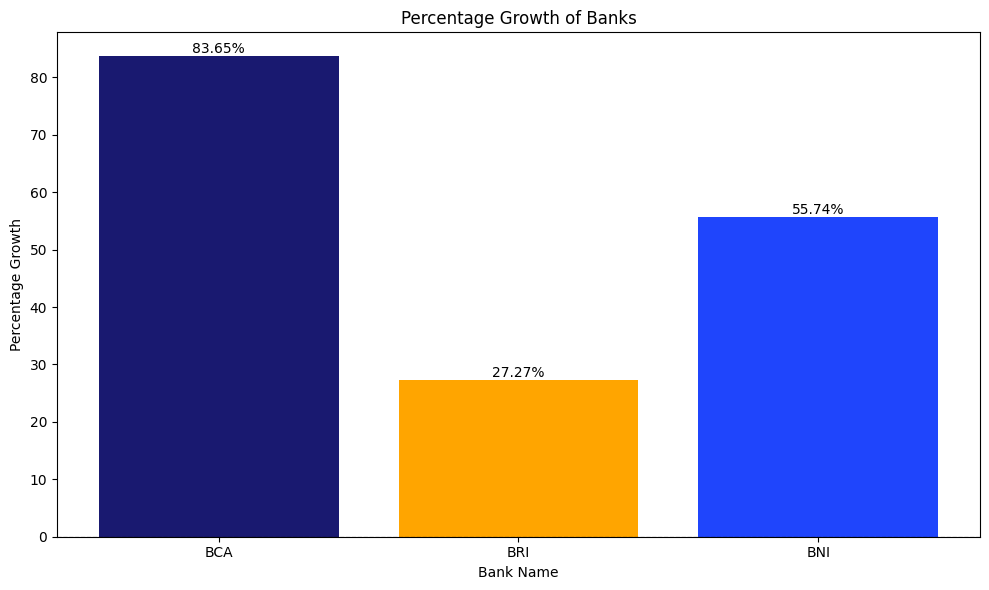

In [12]:
# Find the minimum and maximum closing prices for each bank
mini = [df[df['Date'] == df['Date'].min()]['Close'].values.item() for name, df in df.groupby('Bank_Name')]
maxi = [df[df['Date'] == df['Date'].max()]['Close'].values.item() for name, df in df.groupby('Bank_Name')]

# Calculate the absolute difference between the closing prices
diff = np.array(maxi) - np.array(mini)

# Calculate the percentage growth
growth = (diff / np.array(mini)) * 100

# Convert growth to a list
growth_list = growth.tolist()

# Get the unique bank names
bank_names = df['Bank_Name'].unique()

# Create a dictionary to map bank names to their corresponding growth
growth_dict = dict(zip(bank_names, growth_list))

plt.figure(figsize=(10, 6))
plt.bar(growth_dict.keys(), growth_dict.values(), color=colors)
plt.xlabel('Bank Name')
plt.ylabel('Percentage Growth')
plt.title('Percentage Growth of Banks')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Add a horizontal line at 0 for reference

# Add data labels
for bank_name, growth in growth_dict.items():
    plt.text(bank_name, growth, f"{growth:.2f}%", ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()


- BBCA has the highest share growth percentage from 2019 to present (Jan 2024) followed by BBRI, and then BBNI.

# 3. What was the daily stock returns for each bank?

DAILY RETURN

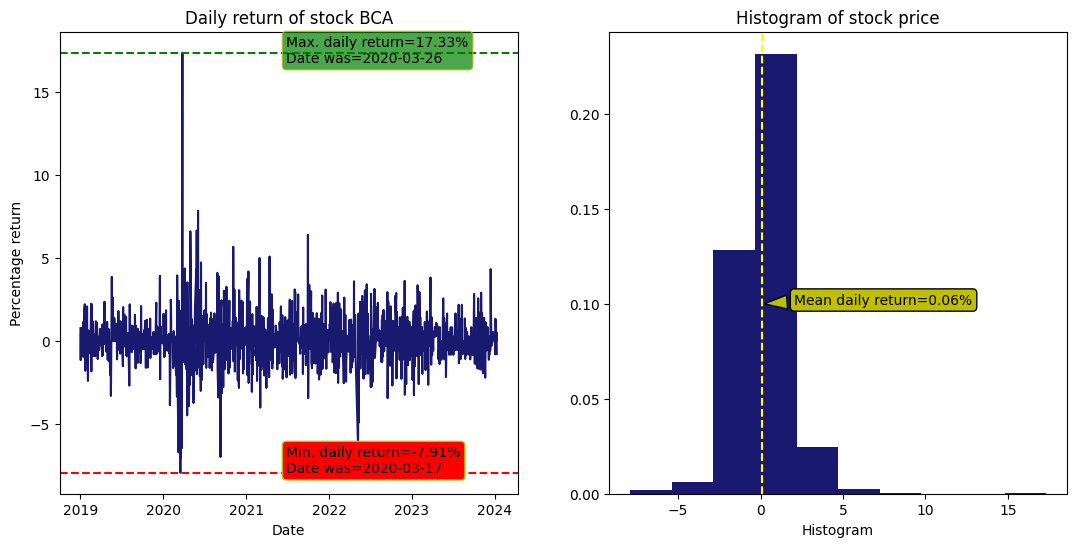

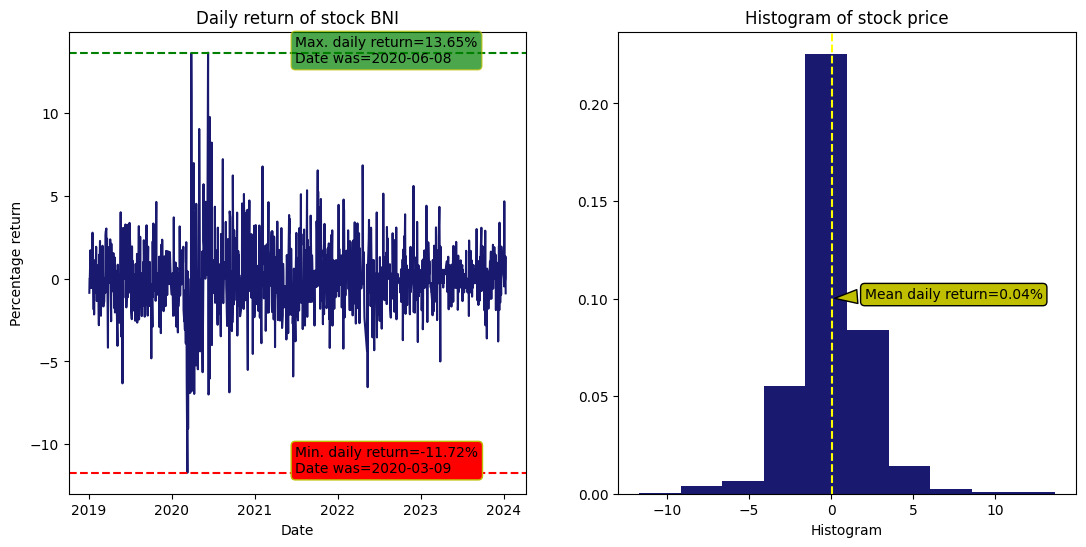

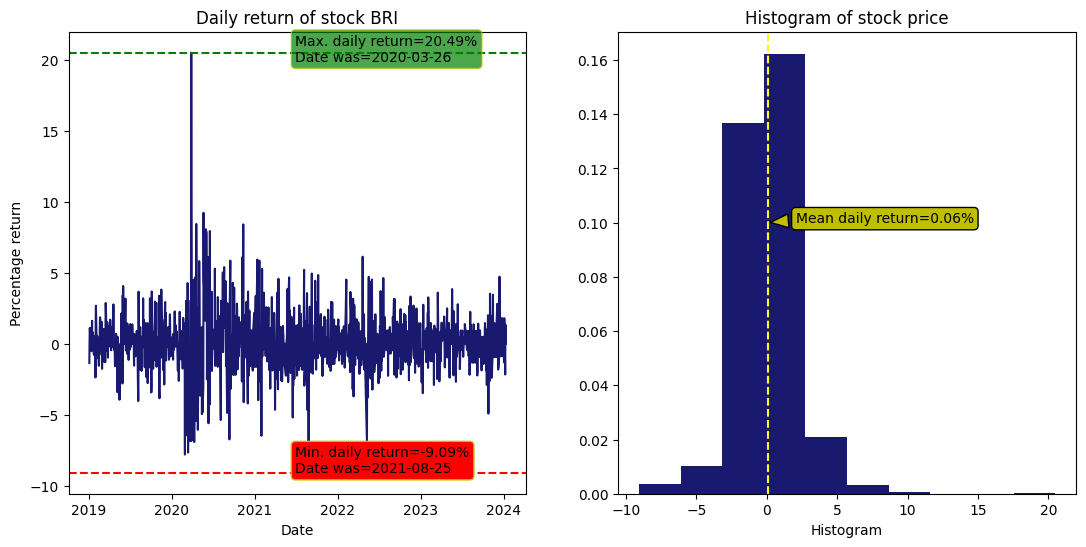

In [13]:
def daily_return(df):
    # Calculate the daily percentage return for each bank
    df['Daily Return'] = df.groupby('Bank_Name')['Close'].pct_change() * 100

    # Assign variables to annotation positions
    ave_x = df['Date'].mean()
    y_max = df['Daily Return'].max()
    y_min = df['Daily Return'].min()
    y_mean = df['Daily Return'].mean()
    y_max_date = df[df['Daily Return'] == y_max]['Date'].values[0]
    y_min_date = df[df['Daily Return'] == y_min]['Date'].values[0]
    xb_max = pd.to_datetime(y_max_date).date()
    xb_min = pd.to_datetime(y_min_date).date()

    # Plotting
    plt.figure(figsize=(13, 6), facecolor='none')  # Set facecolor to 'none' for a transparent background

    # Subplot 1: Line plot of daily returns
    plt.subplot(121)
    plt.plot(df['Date'], df['Daily Return'], color='#191970')
    plt.axhline(y=y_max, color='green', ls='--')  # Add horizontal line for max daily return
    plt.axhline(y=y_min, color='red', ls='--')    # Add horizontal line for min daily return
    plt.xlabel('Date')
    plt.ylabel("Percentage return")
    plt.annotate(f"Max. daily return={round(y_max, 2)}%\nDate was={xb_max}",
                 xy=(ave_x, y_max), xytext=(ave_x, y_max - 0.6),
                 bbox=dict(boxstyle="round", facecolor='g', edgecolor='y', alpha=0.7)
                 )
    plt.annotate(f"Min. daily return={round(y_min, 2)}%\nDate was={xb_min}",
                 xy=(ave_x, y_min), xytext=(ave_x, y_min),
                 bbox=dict(boxstyle="round", facecolor='r', edgecolor='y')
                 )
    plt.title(f"Daily return of stock {df['Bank_Name'].unique()[0]}")

    # Subplot 2: Histogram of daily returns
    plt.subplot(122)
    plt.hist(df['Daily Return'].dropna(), density=True, color='#191970')
    plt.xlabel('Histogram')
    plt.axvline(x=df['Daily Return'].mean(), color='yellow', ls='--')  # Add vertical line for mean daily return
    plt.annotate(f"Mean daily return={round(y_mean, 2)}%",
                 xy=(y_mean, 0.10), xytext=(y_mean + 2, 0.10),
                 bbox=dict(boxstyle="round", facecolor='y'), 
                 arrowprops=dict(arrowstyle="wedge,tail_width=1.", facecolor='y', relpos=(0.1, 0.5)))
    plt.title(f"Histogram of stock price")

    # Show the plot
    plt.show()

# Call the function for each bank
daily_return(df[df['Bank_Name'] == 'BCA'])
daily_return(df[df['Bank_Name'] == 'BNI'])
daily_return(df[df['Bank_Name'] == 'BRI'])

Overall Volatility:

- Maximum daily return for BCA was 13.65%, which occurred on March 26, 2020. The minimum daily return was -7.91%, and it occurred on March 17, 2020.
-  Maximum daily return for BNI was 17.33%, which occurred on June 8, 2020. The minimum daily return was -11.72%, and it occurred on March 9, 2020.
- Maximum daily return for BRI was 20,49%, which occurred on March 26, 2020. The minimum daily return was -9.09%, and it occurred on August 25, 2020.

Distribution of Returns:

- BCA: The distribution appears slightly skewed towards negative returns, suggesting a slightly higher frequency of losses than gains.
- BNI: The distribution is roughly symmetrical, indicating a balance between positive and negative returns.
- BRI: Similar to BCA, the distribution appears slightly skewed towards negative returns.

Range of Daily Returns:

- The majority of daily returns for all three banks fall within a relatively narrow range of -5% to +5%. This suggests that while these stocks can experience significant daily fluctuations, most changes are modest in percentage terms.

# 4. How can one conduct technical analysis of stocks using candlestick charts?

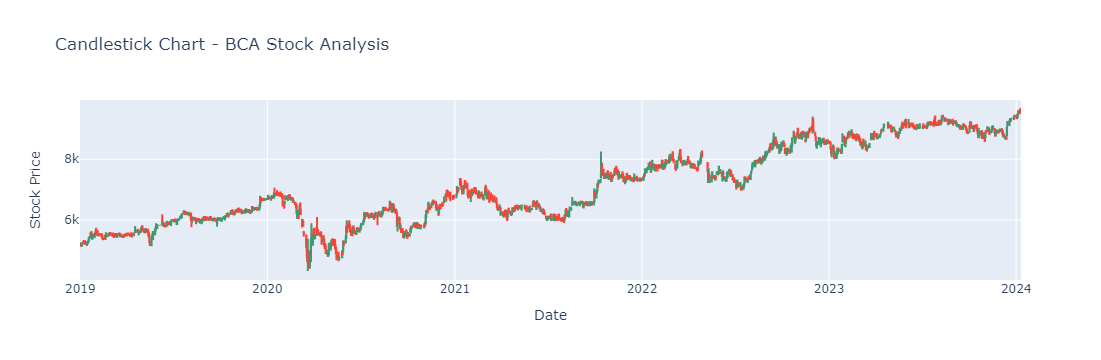

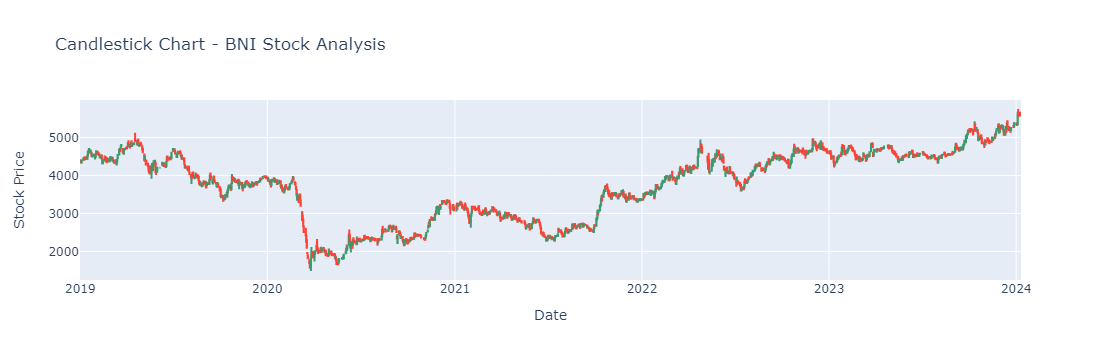

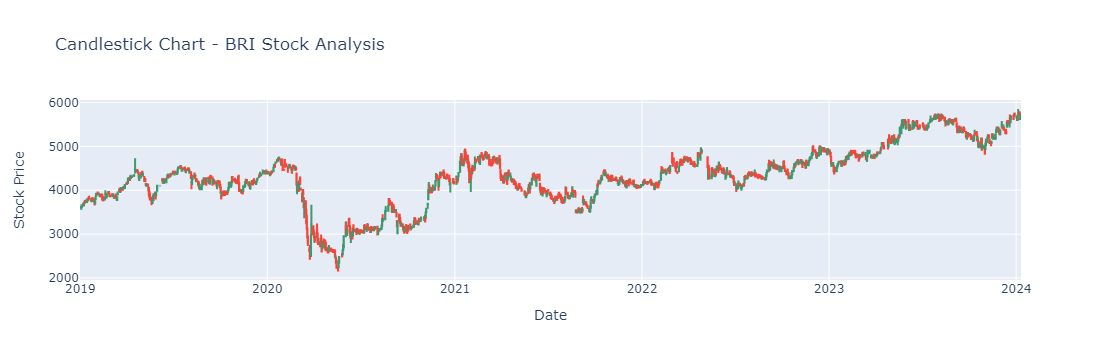

In [14]:
df.sort_values(by=['Bank_Name', 'Date'], inplace=True)

# Create separate candlestick charts for each bank
banks = df['Bank_Name'].unique()

for bank in banks:
    bank_data = df[df['Bank_Name'] == bank]

    fig = go.Figure(data=[go.Candlestick(x=bank_data['Date'],
                                         open=bank_data['Open'],
                                         high=bank_data['High'],
                                         low=bank_data['Low'],
                                         close=bank_data['Close'],
                                         name=bank)])

    # Update layout for better visibility
    fig.update_layout(title=f'Candlestick Chart - {bank} Stock Analysis',
                      xaxis_title='Date',
                      yaxis_title='Stock Price',
                      xaxis_rangeslider_visible=False)

    # Show the chart
    fig.show()


# 5. How effective are LSTM models in forecasting stock prices? and what are the results of forecasting for the next 30 days?

Epoch 1/100
13/13 [==============================] - 10s 327ms/step - loss: 0.0376 - val_loss: 0.0874
Epoch 2/100
13/13 [==============================] - 3s 205ms/step - loss: 0.0084 - val_loss: 0.0125
Epoch 3/100
13/13 [==============================] - 3s 199ms/step - loss: 0.0051 - val_loss: 0.0033
Epoch 4/100
13/13 [==============================] - 3s 236ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 5/100
13/13 [==============================] - 3s 253ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 6/100
13/13 [==============================] - 3s 249ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 7/100
13/13 [==============================] - 3s 248ms/step - loss: 0.0027 - val_loss: 0.0018
Epoch 8/100
13/13 [==============================] - 3s 202ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 9/100
13/13 [==============================] - 3s 197ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 10/100
13/13 [==============================] - 3s 250ms/step - loss: 0.0024 - val_l

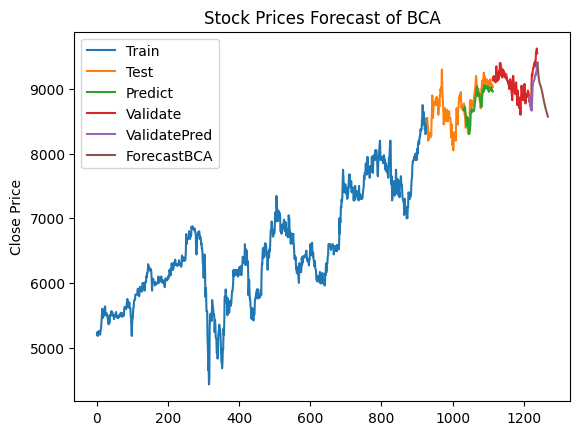

Validation RMSE: 200.76149623173313
Testing RMSE: 120.87498219145635
Validation MAE: 165.465576171875
Testing MAE: 98.96734328497024
Validation MAPE: 0.01822034848231556
Testing MAPE: 0.011262984021077864
Epoch 1/100
13/13 [==============================] - 9s 287ms/step - loss: 0.0444 - val_loss: 0.0443
Epoch 2/100
13/13 [==============================] - 2s 192ms/step - loss: 0.0097 - val_loss: 0.0017
Epoch 3/100
13/13 [==============================] - 3s 221ms/step - loss: 0.0053 - val_loss: 9.0861e-04
Epoch 4/100
13/13 [==============================] - 3s 245ms/step - loss: 0.0042 - val_loss: 0.0015
Epoch 5/100
13/13 [==============================] - 3s 250ms/step - loss: 0.0036 - val_loss: 0.0010
Epoch 6/100
13/13 [==============================] - 3s 223ms/step - loss: 0.0033 - val_loss: 0.0015
Epoch 7/100
13/13 [==============================] - 3s 195ms/step - loss: 0.0031 - val_loss: 0.0016
Epoch 8/100
13/13 [==============================] - 3s 201ms/step - loss: 0.0030 - 

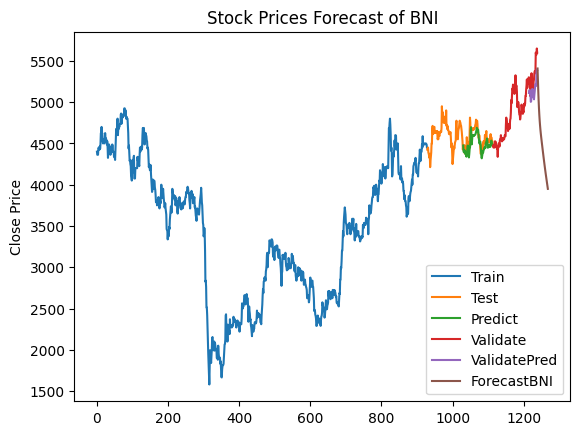

Validation RMSE: 189.35848726990497
Testing RMSE: 91.56277640121357
Validation MAE: 171.008056640625
Testing MAE: 77.94762602306548
Validation MAPE: 0.03318336204138158
Testing MAPE: 0.017356632053544326
Epoch 1/100
13/13 [==============================] - 9s 320ms/step - loss: 0.1117 - val_loss: 0.0212
Epoch 2/100
13/13 [==============================] - 3s 223ms/step - loss: 0.0132 - val_loss: 0.0093
Epoch 3/100
13/13 [==============================] - 3s 272ms/step - loss: 0.0087 - val_loss: 0.0276
Epoch 4/100
13/13 [==============================] - 3s 234ms/step - loss: 0.0066 - val_loss: 0.0216
Epoch 5/100
13/13 [==============================] - 3s 217ms/step - loss: 0.0058 - val_loss: 0.0140
Epoch 6/100
13/13 [==============================] - 4s 285ms/step - loss: 0.0051 - val_loss: 0.0078
Epoch 7/100
13/13 [==============================] - 4s 285ms/step - loss: 0.0046 - val_loss: 0.0069
Epoch 8/100
13/13 [==============================] - 4s 292ms/step - loss: 0.0044 - val_l

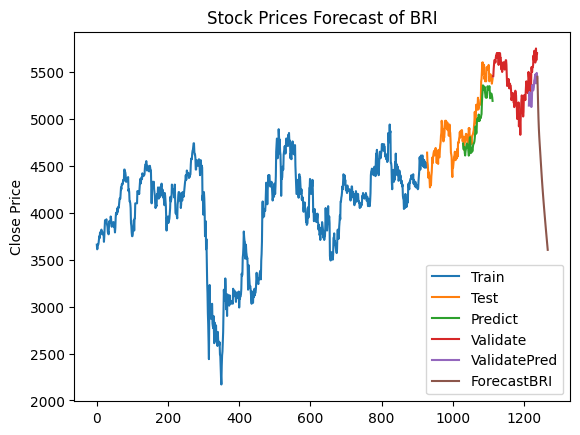

Validation RMSE: 248.45099930273432
Testing RMSE: 172.49200848019476
Validation MAE: 234.75113932291666
Testing MAE: 155.86261276971726
Validation MAPE: 0.0441963958032259
Testing MAPE: 0.03102867859292811


In [15]:
def forecast_stock(df_stock, stock_name, time_step=100, n_steps=77, epochs=100, batch_size=64):
    # 1. Group by Date and calculate the mean of the 'Close' column
    df1 = df_stock.groupby('Date')['Close'].mean()

    # 2. Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

    # 3. Split the data into train, test, and validation sets
    train_size = int(0.75 * len(df1))
    test_size = int(0.15 * len(df1))
    val_size = len(df1) - train_size - test_size

    train_data = df1[:train_size]
    test_data = df1[train_size:train_size+test_size]
    val_data = df1[train_size+test_size:]

    # 4. Create dataset function
    def create_dataset(dataset, time_step=1):
        dataX, dataY = [], []
        for i in range(len(dataset) - time_step - 1):
            a = dataset[i:(i + time_step), 0]
            dataX.append(a)
            dataY.append(dataset[i + time_step, 0])
        return np.array(dataX), np.array(dataY)

    # 5. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
    X_train, y_train = create_dataset(train_data, time_step)
    X_val, y_val = create_dataset(val_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)

    # 6. Reshape input to be [samples, time steps, features] which is required for LSTM
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

    # 7. Define LSTM Model with modified learning rate
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1))

    # Use Adam optimizer with a lower learning rate
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mean_squared_error', optimizer=optimizer)

    # 8. Fit the model with training data
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1)

    # 9. Predictions
    train_predict = model.predict(X_train)
    y_pred = model.predict(X_test)
    y_pred_val = model.predict(X_val)

    # 10. Inverse transform predictions
    train_predict = scaler.inverse_transform(train_predict)
    y_pred = scaler.inverse_transform(y_pred)
    y_pred_val = scaler.inverse_transform(y_pred_val)

    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_val = scaler.inverse_transform(y_val.reshape(-1, 1))

    # 11. Forecast the next 30 days
    x_input = val_data[-n_steps:].reshape(1, -1)
    temp_input = list(x_input[0])

    lst_output = []
    n_forecast_steps = 30
    i = 0
    while i < n_forecast_steps:
        if len(temp_input) > n_steps:
            x_input = np.array(temp_input[1:])
            x_input = x_input.reshape(1, -1)
            x_input = x_input.reshape((1, n_steps, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            while len(temp_input) < n_steps:
                temp_input.insert(0, 0)

            x_input = np.array(temp_input[-n_steps:])
            x_input = x_input.reshape((1, n_steps, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1

    # 12. Plotting
    train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
    plt.plot(scaler.inverse_transform(train_data))
    test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
    plt.plot(test_data_index, scaler.inverse_transform(test_data))
    test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
    plt.plot(test_data_index, y_pred)
    val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
    plt.plot(val_data_index, scaler.inverse_transform(val_data))
    val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
    plt.plot(val_data_index, y_pred_val)
    forecast_data_index = pd.RangeIndex(start=len(df1), stop=len(df1)+n_forecast_steps, step=1)
    plt.plot(forecast_data_index, scaler.inverse_transform(lst_output))
    plt.legend(['Train', 'Test', 'Predict', 'Validate', 'ValidatePred', f'Forecast{stock_name}'])
    plt.title(f'Stock Prices Forecast of {stock_name}')
    plt.ylabel('Close Price')
    plt.show()

    # 13. Evaluate the model
    valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
    test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
    print('Validation RMSE:', valid_rmse)
    print('Testing RMSE:', test_rmse)

    valid_mae = np.mean(abs(y_pred_val - y_val))
    test_mae = np.mean(abs(y_pred - y_test))
    print('Validation MAE:', valid_mae)
    print('Testing MAE:', test_mae)

    valid_mape = np.mean(np.abs(y_pred_val - y_val) / np.abs(y_pred_val))
    test_mape = np.mean(np.abs(y_pred - y_test) / np.abs(y_pred))
    print('Validation MAPE:', valid_mape)
    print('Testing MAPE:', test_mape)

# Call the function for each stock
forecast_stock(df_bca, 'BCA')
forecast_stock(df_bni, 'BNI')
forecast_stock(df_bri, 'BRI')

Key findings:
- The LSTM model appears to be effective in capturing patterns in the data, as reflected by the low MAPE values.
- The slightly better performance on the validation set compared to the testing set raises concerns about potential overfitting, and further steps should be taken to address this.

The evaluation metrics for the forecast of BCA using LSTM models provide valuable insights into the model's performance. Based on RMSE and MAE results, the model performed slightly better on the validation dataset, suggesting it may have overfitted the training data to some extent. It's essential to assess whether the model can generalize well to unseen data. The MAPE scores indicate relatively good accuracy, especially since they fall below the 5% threshold. However, caution is warranted due to market volatility, and the model should be considered as part of a broader analysis.

Based on forecasting results using the LSTM model for the next 30 days, it can be seen that only BBCA shares are expected to increase, while BBNI and BBRI shares are predicted to experience a decline. 
But besides that, it's important to note that stock price forecasting is inherently challenging due to the dynamic nature of financial markets, and no model can guarantee accurate predictions.


# 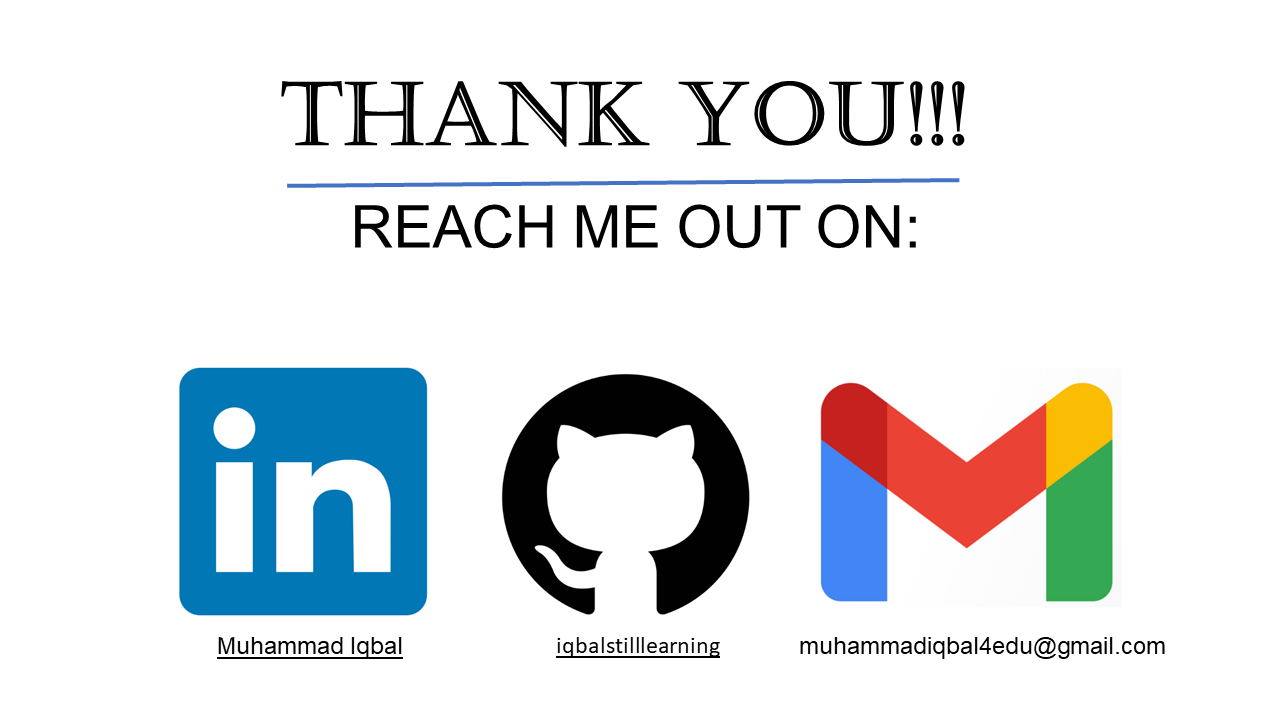

**Links: [[Linkedin](https://www.linkedin.com/in/muhammadiqbal-/)] [[Github](https://github.com/iqbalstilllearning/)] [[Gmail](muhammadiqbal4edu@gmail.com)]**